In [28]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
import pandas as pd

import HELP
gmod = HELP.get_model
makmod = HELP.make_spotmodel
Dotter_rad = HELP.Dotter_rad

import getMag
getMag = getMag.getMag

import getMag_hires
getMag_hires = getMag_hires.getMag_hires

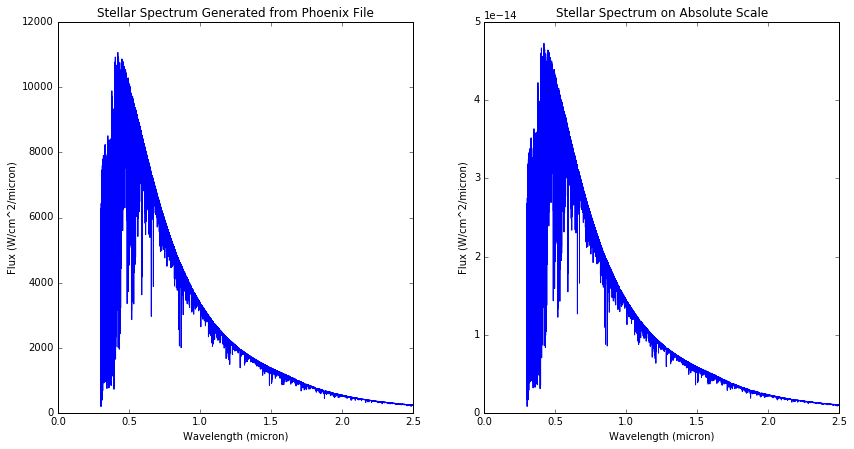

In [29]:
PhTemp = '5800'
SpTemp = '5800'
FillFactor = .2
wavelength,flux_Phoenix,PhTemp,SpTemp,FillFactor = makmod(PhTemp,SpTemp,FillFactor) #Creates spectrum for desired temps and fill-factor
Flux = Dotter_rad( PhTemp, flux_Phoenix )

plt.figure(figsize = (14,7))
plt.subplot(121)
plt.plot(wavelength,flux_Phoenix)
plt.title('Stellar Spectrum Generated from Phoenix File')
plt.xlabel('Wavelength (micron)')
plt.ylabel(r'Flux (W/cm^2/micron)')

plt.subplot(122)
plt.plot(wavelength,Flux)
plt.title('Stellar Spectrum on Absolute Scale')
plt.xlabel('Wavelength (micron)')
plt.ylabel(r'Flux (W/cm^2/micron)')

[('U', 0.365, 5.759067669770582), ('B', 0.445, 5.6207500916502084), ('V', 0.551, 4.9873442775360353), ('R', 0.658, 4.665521066171797), ('I', 0.806, 4.3644285195983379), ('J', 1.235, 3.8523143669529549), ('H', 1.662, 3.5336828281312349), ('Ks', 2.159, 3.4734758714095282)]


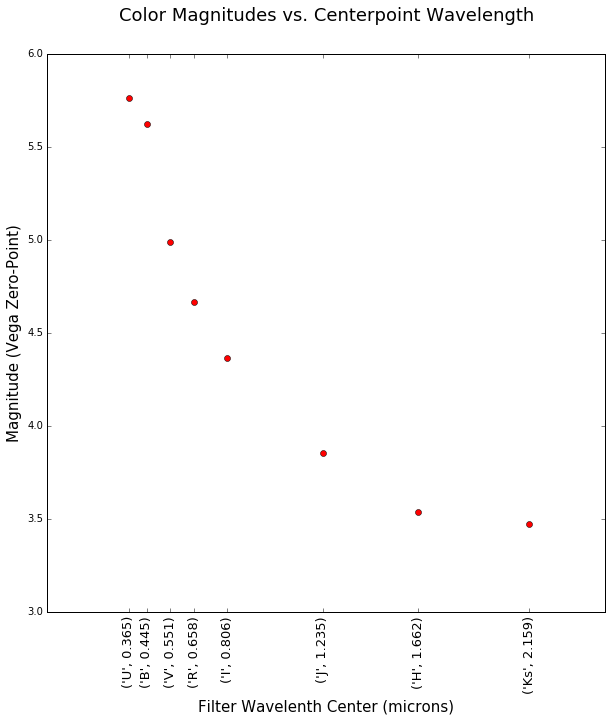

In [30]:
#initialize arrays of filter names
bands = np.array(['U','B','V','R','I','J','H','Ks'])
bands_hires = ['Ks','H','J']


#fill up a 3D array 'syn_phot' with: filter name, center point, magnitude
syn_phot = []
for i in range(len(bands)):
    x = getMag(bands[i],wavelength,Flux,'microns') #x returns three values; band, center, mag
    syn_phot.append(x)
    
#syn_phot_hires = []
#for i in range(len(bands_hires)):
#    y = getMag_hires(bands_hires[i],wavelength,tot_flux,'angstrom') #y returns three values; band, center, mag
#    syn_phot_hires.append(y)



print(syn_phot)

Filters = [i[0] for i in syn_phot]
Centers = [i[1] for i in syn_phot]
Magnitudes = [i[2] for i in syn_phot]

plt.figure(figsize=(10,10))
plt.plot(Centers,Magnitudes,'ro')
plt.title('Color Magnitudes vs. Centerpoint Wavelength', fontsize=18,y=1.05)

xlab = list(zip(Filters,Centers)) #Could use some cleaning up

plt.xticks(Centers,xlab,rotation='vertical',fontsize='13')
plt.xlabel('Filter Wavelenth Center (microns)', fontsize=15)
plt.ylabel('Magnitude (Vega Zero-Point)', fontsize=15)

#centers_hires = [i[1] for i in syn_phot_hires]
#magnitudes_hires = [i[2] for i in syn_phot_hires]
#plt.plot(centers_hires,magnitudes_hires,'bo')